# 4주차 Vision Basic 과제

### 1. 이미지 처리에 있어 Traditional 신경망이 가지는 문제

In [ ]:
from torchvision import datasets
import torch
data_folder = './data' # 해당 경로 폴더에 FashionMNIST 데이터셋을 다운로드
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)

In [2]:
# 학습 이미지와 레이블
tr_images = fmnist.data
tr_targets = fmnist.targets

In [3]:
# 평가 이미지와 레이블
val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

(28, 28)


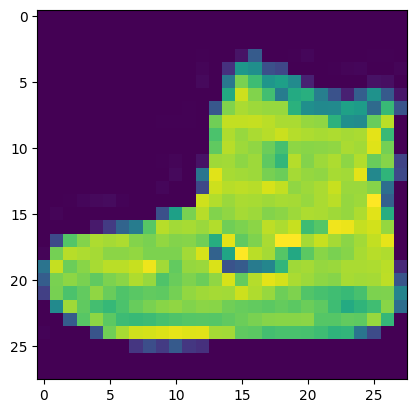

In [4]:
## 이미지 시각화 및 크기 확인

import PIL.Image as Image
import matplotlib.pyplot as plt
img = Image.fromarray(tr_images[0].numpy())
plt.imshow(img)
print(img.size)

In [5]:
%matplotlib inline
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [6]:
# FashionMNIST 데이터셋을 Dataset 클래스로 만들기

class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1,28*28)
        self.x, self.y = x, y
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    def __len__(self):
        return len(self.x)

from torch.optim import SGD, Adam

# 간단한 Linear 신경망 정의

def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

def accuracy(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()


In [7]:
def get_data():
    train = FMNISTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=False)
    return trn_dl, val_dl

In [8]:
def val_loss(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [9]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [10]:
# 정의한 모델을 이용하여 학습, 평가
# epoch 당 loss, accuracy 저장 및 출력

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(f"epoch : {epoch}" )
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)
    print(f"train_loss : {train_epoch_loss:.4f}, train_accuracy : {train_epoch_accuracy:.4f}, val_loss : {validation_loss:.4f}, val_accuracy : {val_epoch_accuracy:.4f}")

epoch : 0
train_loss : 0.4733, train_accuracy : 0.8656, val_loss : 0.4083, val_accuracy : 0.8518
epoch : 1
train_loss : 0.3575, train_accuracy : 0.8812, val_loss : 0.3765, val_accuracy : 0.8640
epoch : 2
train_loss : 0.3216, train_accuracy : 0.8953, val_loss : 0.3479, val_accuracy : 0.8723
epoch : 3
train_loss : 0.2953, train_accuracy : 0.9018, val_loss : 0.3405, val_accuracy : 0.8800
epoch : 4
train_loss : 0.2768, train_accuracy : 0.9009, val_loss : 0.3485, val_accuracy : 0.8738


- 학습 데이터셋의 Index 24300 (무작위 인덱스) 이미지를 학습 모델에 투입하여 예측값 확인
  - Trouser 클래스(1번 클래스)의 확률이 가장 큼

Text(0.5, 1.0, 'Trouser')

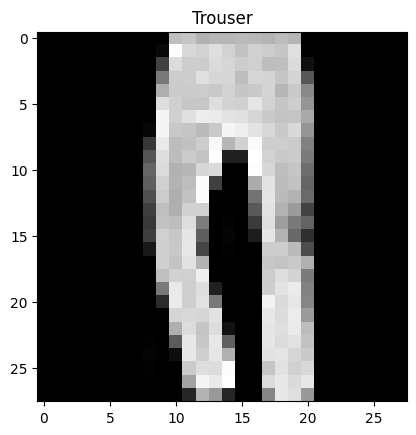

In [ ]:
#ix = np.random.randint(len(tr_images))
ix = 24300
plt.imshow(tr_images[ix], cmap='gray')
plt.title(fmnist.classes[tr_targets[ix]])

- Translation
  - np.roll 함수를 사용하여 Index 24300 이미지를 좌우로 이동 (범위 -5~+5)

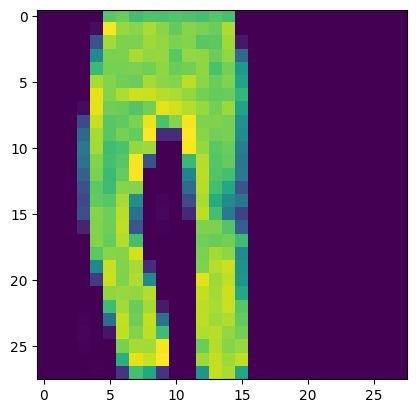

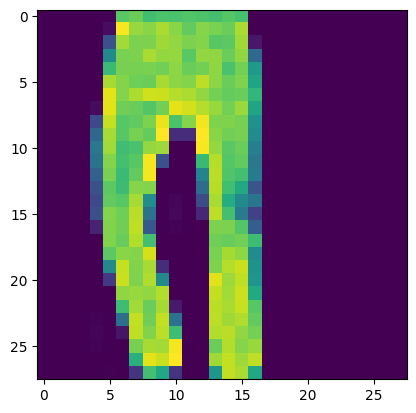

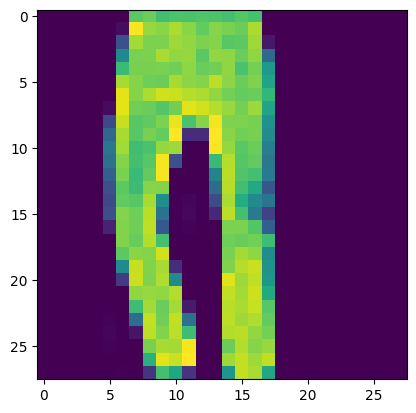

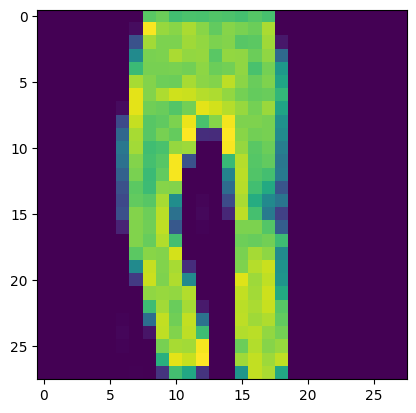

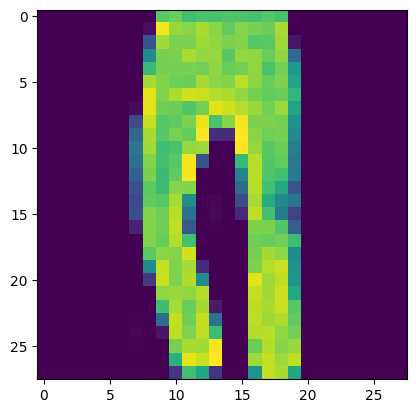

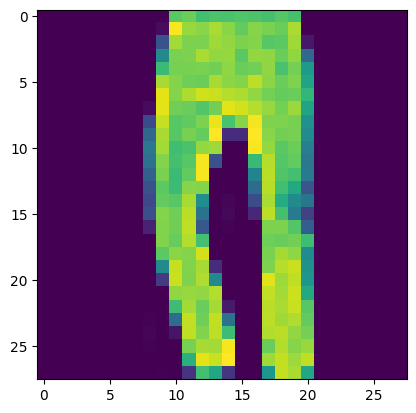

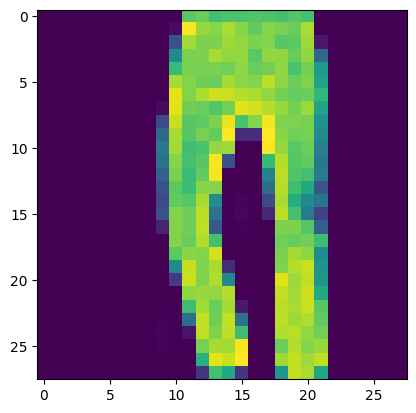

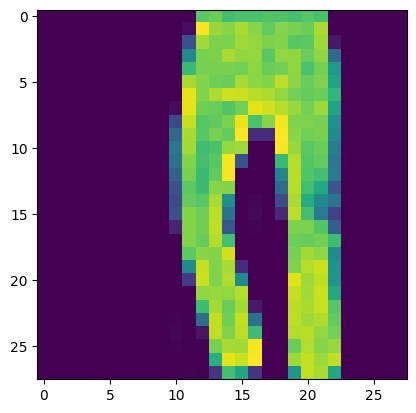

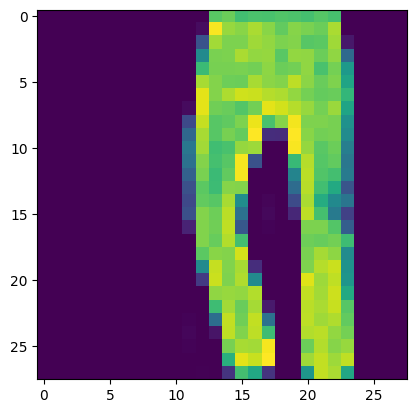

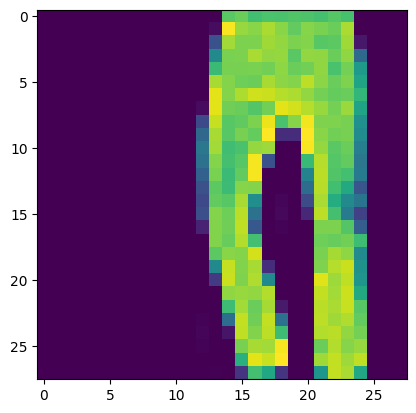

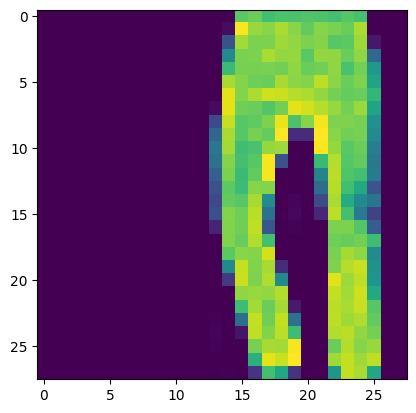

In [ ]:
preds = []
for px in range(-5,6):
  img = tr_images[ix]/255.
  img = img.view(28, 28)
  #img2 = np.zeros((28,28))
  img2 = np.roll(img, px, axis=1)
  plt.imshow(img2)
  plt.show()
  img3 = torch.Tensor(img2).view(28*28).to(device)
  np_output = model(img3).cpu().detach().numpy()
  preds.append(np.exp(np_output)/np.sum(np.exp(np_output)))

#### 결과 확인

<Axes: title={'center': 'Probability of each class for various translations'}>

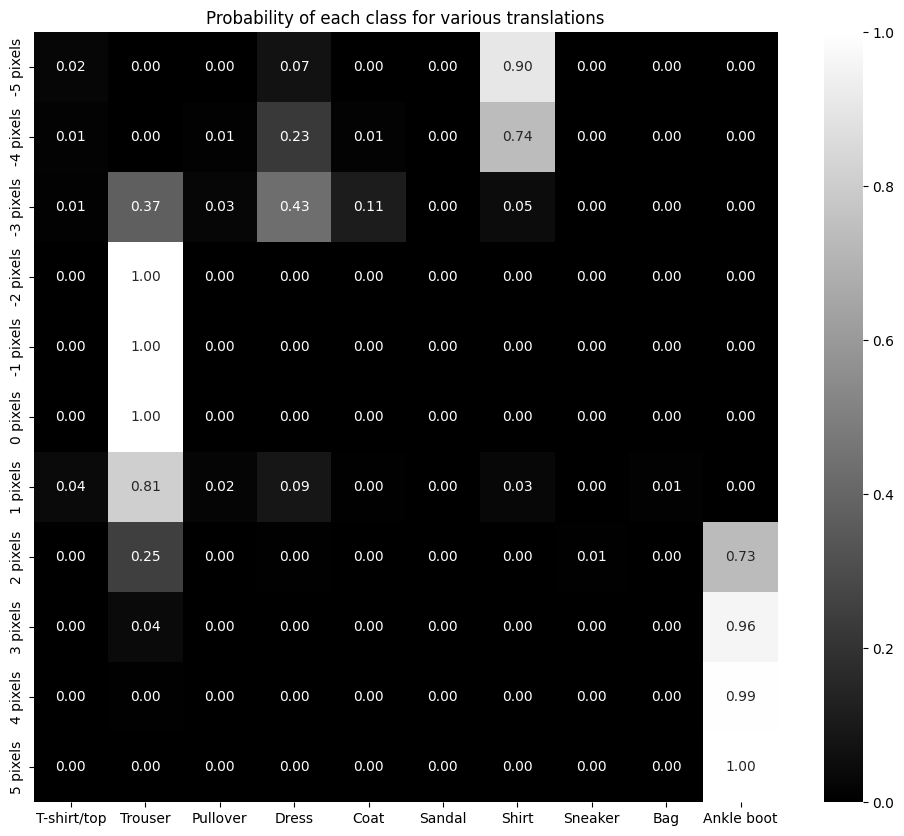

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(12,10))
plt.title('Probability of each class for various translations')
sns.heatmap(np.array(preds), annot=True, ax=ax, fmt='.2f', xticklabels=fmnist.classes, yticklabels=[str(i)+str(' pixels') for i in range(-5,6)], cmap='gray')

#### traditional한 방식으로 신경망을 이용하여 이미지를 분류하는 경우 픽셀을 좌우로 움직인 것만으로 다른 분류 결과를 도출한다. 이는 모델이 robust하지 않다는 것을 의미한다. 실제로 3 pixels 이상 움직이는 경우 최종적으로 도출된 분류 결과가 달라지는 양상을 확인할 수 있다. 때문에 전통적인 방법은 전형적인 overfit 문제가 발생한다고 해석할 수 있을 것이다.

- 위 히트맵에서 세로축은 동일한 이미지를 좌우로 이동한 픽셀 수를 나타내며,
- 가로축은 각 클래스에 대한 확률을 나타냅니다.

### 2. 합성곱 신경망 활용, FashionMNIST 이미지 분류

In [11]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1,1,28,28)
        self.x, self.y = x, y
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    def __len__(self):
        return len(self.x)

- 아래 모델 summary를 보고 컨폴루션 레이어 안의 파라미터를 작성해주세요.
- stride = 1 (default), padding = 0으로 통일입니다.

In [35]:
from torch.optim import SGD, Adam

def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3), # 흑백의 단일 채널이므로 입력 채널을 1로 출력 채널을 64(64개의 필터)로 설정, 26*26 차원으로 만들어야 하므로 (input-kernel)/stride + 1 = 26이 되어야 함. 따라서 kernel은 3
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(3200,256),
        nn.ReLU(),
        nn.Linear(256, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()


In [30]:
@torch.no_grad()
def val_loss(x, y, model):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [31]:
trn_dl, val_dl = get_data()

In [ ]:
#!pip install torch_summary
from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model,(1,28,28));

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 26, 26]             640
         MaxPool2d-2           [-1, 64, 13, 13]               0
              ReLU-3           [-1, 64, 13, 13]               0
            Conv2d-4          [-1, 128, 11, 11]          73,856
         MaxPool2d-5            [-1, 128, 5, 5]               0
              ReLU-6            [-1, 128, 5, 5]               0
           Flatten-7                 [-1, 3200]               0
            Linear-8                  [-1, 256]         819,456
              ReLU-9                  [-1, 256]               0
           Linear-10                   [-1, 10]           2,570
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.69
Params size (MB): 3.42
Estimated T

In [37]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(f"epoch : {epoch}")
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

    print(f"train_loss : {train_epoch_loss:.4f}, train_accuracy : {train_epoch_accuracy:.4f}, val_loss : {validation_loss:.4f}, val_accuracy : {val_epoch_accuracy:.4f}")

epoch : 0
train_loss : 0.4261, train_accuracy : 0.8899, val_loss : 0.3367, val_accuracy : 0.8792
epoch : 1
train_loss : 0.2764, train_accuracy : 0.9079, val_loss : 0.2941, val_accuracy : 0.8887
epoch : 2
train_loss : 0.2307, train_accuracy : 0.9283, val_loss : 0.2661, val_accuracy : 0.9052
epoch : 3
train_loss : 0.1978, train_accuracy : 0.9376, val_loss : 0.2601, val_accuracy : 0.9060
epoch : 4
train_loss : 0.1669, train_accuracy : 0.9529, val_loss : 0.2528, val_accuracy : 0.9126


### Plotting
- Fully-connected 레이어 기반 모델 대비 성능이 향상된 것을 확인할 수 있음

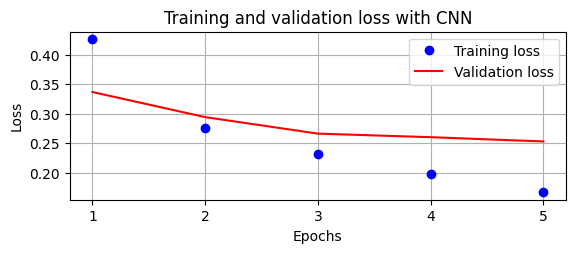

<ipython-input-38-fa390bbbb778>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


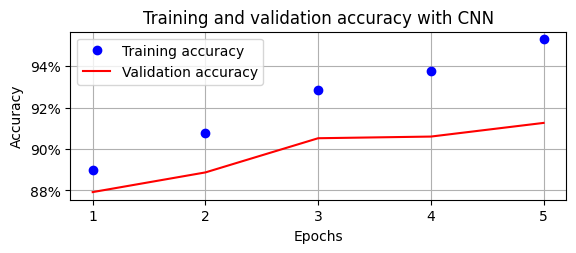

In [38]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()

- 이미지를 이동시켰을 때, 성능이 어떻게 변화하는지 확인

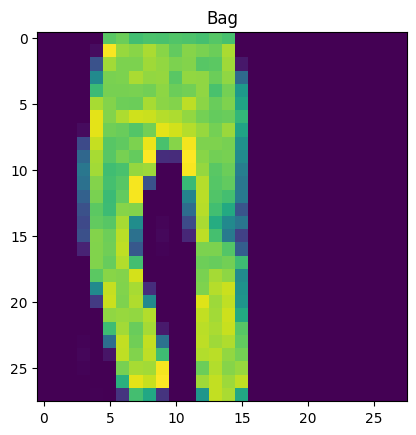

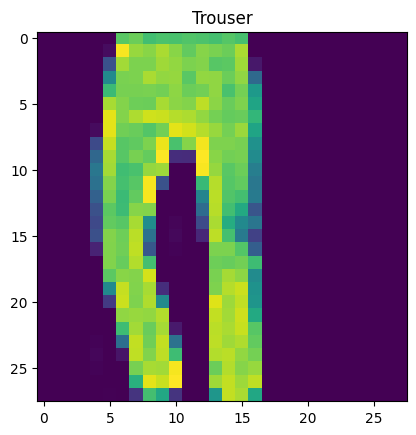

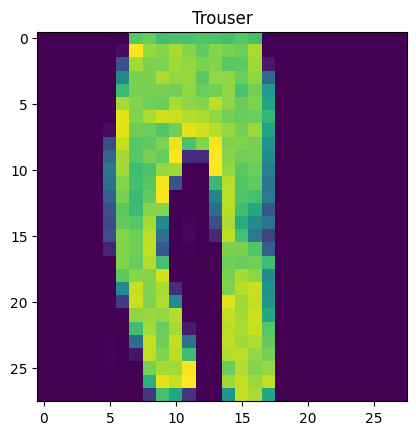

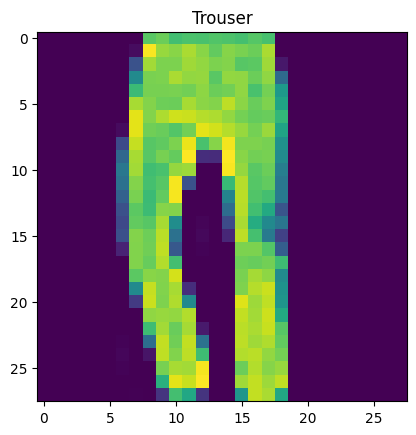

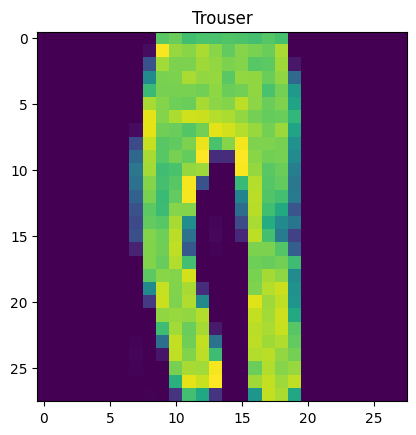

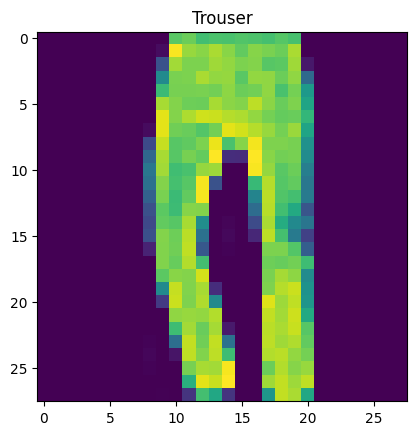

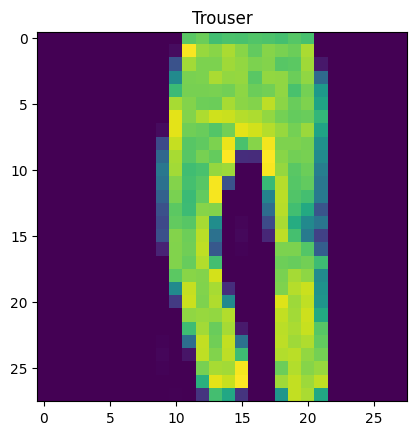

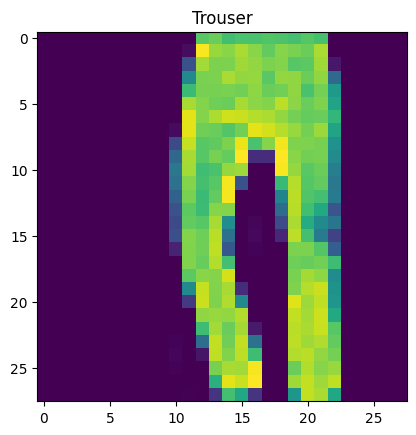

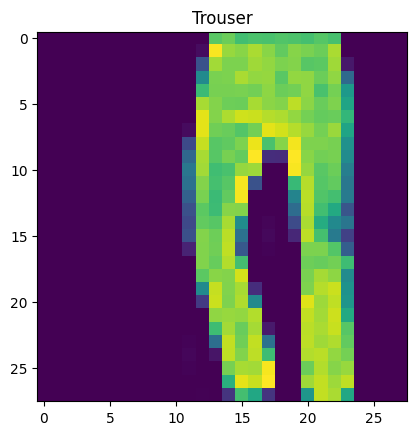

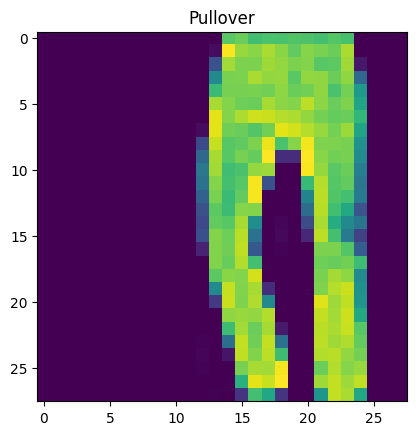

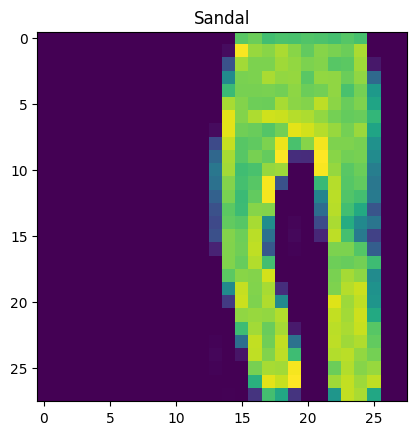

In [39]:
preds = []
ix = 24300
for px in range(-5,6):
  img = tr_images[ix]/255.
  img = img.view(28, 28)
  img2 = np.roll(img, px, axis=1)
  img3 = torch.Tensor(img2).view(-1,1,28,28).to(device)
  np_output = model(img3).cpu().detach().numpy()
  pred = np.exp(np_output)/np.sum(np.exp(np_output))
  preds.append(pred)
  plt.imshow(img2)
  plt.title(fmnist.classes[pred[0].argmax()])
  plt.show()

In [40]:
np.array(preds).shape # -5~+5로 이동시켜 가며(총 11 case), 10개 class로 분류될 확률 예측

(11, 1, 10)

<Axes: title={'center': 'Probability of each class for various translations'}>

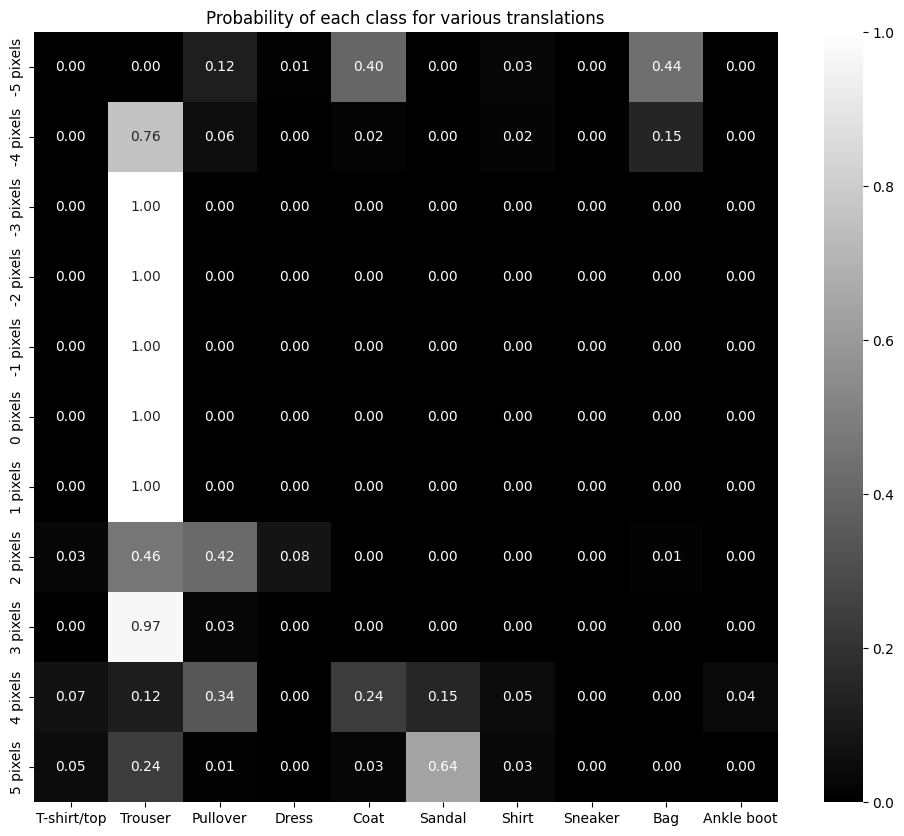

In [41]:
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(12,10))
plt.title('Probability of each class for various translations')
sns.heatmap(np.array(preds).reshape(11,10), annot=True, ax=ax, fmt='.2f', xticklabels=fmnist.classes, yticklabels=[str(i)+str(' pixels') for i in range(-5,6)], cmap='gray')

- 위 FC 신경망의 인사이트와 비교해서, 인사이트를 작성해주세요.

#### FC 신경망과 비교해서 3 pixel 내의 이동까지는 동일한 분류 결과를 유지하는 모습을 확인할 수 있었다. 이는 모델이 robust해져서 noise에도 더욱 견고해짐과 동시에, 실제 예측을 수행할 때 더욱 높은 성능을 보일 수 있음을 의미한다. 다만 여전히 4 pixel 이상을 움직였을 때 예측 성능이 떨어지는 모습을 보였다.

# 3 ResNet BasicBlock 구현

- ResNet Basic Block 구현 과제 입니다.
- conv Sequential layer에는 Conv2d, ReLU를 포함해주세요.
- 순전파 함수에는 Skip Connection을 구현해주세요.

In [42]:
class ResLayer(nn.Module):
     def __init__(self,input,output,kernel_size=3,stride=1,padding=1):
        super(ResLayer, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input, output, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(inplace=True),
            nn.Conv2d(output, output, kernel_size=kernel_size, stride=1, padding=padding),
            nn.ReLU(inplace=True)
        )

     def forward(self, x):

        # 순전파: Conv 레이어를 거친 출력
        conv_out = self.conv(x)

        # Skip Connection 구현 (입력과 변환된 출력 더하기)
        skip_out = self.skip_connection(x)

        return conv_out + skip_out